# This is a grey world.

The goal of this project is to creat colored pictures out of thrre grey pictures, took in RGB. The input data is one picture, made with the 3 grey pictures. The problem will consist on finding how to align the 3 pictures.

## Separate the picture in 3.

First task is to cut the input picture and to cut in in 3 pictures.

In [32]:
import cv2
import numpy
from matplotlib import pyplot as plt

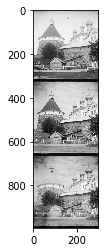

In [78]:
im = cv2.imread("01.png")
im_grey = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
im_grey = im_grey[15:-15,50:-50]

plt.imshow(im_grey, cmap='gray')
plt.show()

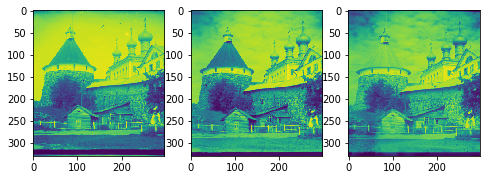

(330, 298)
(330, 298)
(330, 298)


In [79]:
height, width = im_grey.shape
im_red = im_grey[0:height//3, : ]
im_green = im_grey[height//3+1 : 2*(height//3), : ]
im_blue = im_grey[2*(height//3)+1:, : ]

good_h = min(im_red.shape[0], im_blue.shape[0], im_green.shape[0])
good_w = min(im_red.shape[1], im_blue.shape[1], im_green.shape[1])
im_red, im_blue, im_green = im_red[:good_h, :good_w], im_blue[:good_h, :good_w], im_green[:good_h, :good_w]

rows = 1
columns = 3
fig = plt.figure(figsize = (8,8))
fig.add_subplot(rows, columns, 1)
plt.imshow(im_red)
fig.add_subplot(rows, columns, 2)
plt.imshow(im_green)
fig.add_subplot(rows, columns, 3)
plt.imshow(im_blue)

plt.show()

print(im_blue.shape)
print(im_green.shape)
print(im_red.shape)

## Finding the common corner.

To find the common corner of those 3 images, we need to define the fonction indicating wheter the two images are well supperposed or not. To be compared, those images must have the same shape, so we need a function to reshape images depending of their relative top left corner.

This function will also help us reshaping the images before using them to make the final coloured image.

In [80]:
def evaluate_superposition(a,b):
    if a.shape != b.shape :
        # print("These two images don't have the same shape, therefore we can't compare them")
        # for some reasons this happends a lot and takes time to print.
        return(0)
    h,w = a.shape
    val = 0
#     val = numpy.sum(a*b)
    val = numpy.square(a-b)
    val = numpy.sum(val)
#     for i in range(0,h):
#         for j in range(0,w):
#             val += a[i, j]*b[i, j]
    # we return the sum, divided by the numper of pixels in the image (so the dimensions after reshaping doesn't affect the result)
    # print(val/(a.shape[0] * a.shape[1]))
    return(val)
    
def reshape2(a,b,b_corner):
    # we have 4 different cases depending on wheter one corner is above/below/on the left/on the right of the other.
    # we only have to treat two cases, the other two can be treated by switching a and b.
    
    switched = False
    if 0 < b_corner[0] and 0 < b_corner[1] or 0 > b_corner[0] and 0 > b_corner[1] :
        if 0 > b_corner[0] : 
            a,b = b,a
            switched = True
        # reshape
        a, b = a[abs(b_corner[0]) : min(abs(b_corner[0]) + b.shape[0], a.shape[0]), 
                 abs(b_corner[1]) : min(abs(b_corner[1]) + b.shape[1], a.shape[1])], b[:min(b.shape[0], a.shape[0] - abs(b_corner[0])),
                                                                             : min(b.shape[1], a.shape[1] - abs(b_corner[1]))]
    
    if 0 < b_corner[0] and 0 > b_corner[1] or 0 > b_corner[0] and 0 < b_corner[1] :
        if 0 > b_corner[0] : 
            a,b = b,a
            switched = True
        #reshape
        a, b = a[abs(b_corner[0]) : min(abs(b_corner[0]) + b.shape[0], a.shape[0]), 
                : min(a.shape[1], b.shape[1] - abs(b_corner[1]))], b[:min(b.shape[0], a.shape[0] - abs(b_corner[0])), 
                                                                   abs(b_corner[1]) : min(abs(b_corner[1]) + a.shape[1], b.shape[1])]
    if switched : 
        return(b,a)
    else:
        return(a,b)

def reshape(a, image, b_corner):
    x_offset, y_offset = b_corner
    res = image.copy()
    res = numpy.roll(res,x_offset,axis=1)
    res = numpy.roll(res,y_offset,axis=0)

#     for i in range(image.shape[0]):
#         for j in range(image.shape[1]):
#             res[i, j] = image[(i + x_offset) % image.shape[0], (j + y_offset) % image.shape[1]]
    return(a, res)
    
# some tests to try the reshaping function.

# test_corner = (10, 20)
    
# im_red_t,im_green_t = reshape(im_red, im_green, test_corner)
# im_green_t_2, im_useless = reshape2(im_green, im_red, test_corner)

# rows = 1
# columns = 3
# fig = plt.figure(figsize = (8,8))
# fig.add_subplot(rows, columns, 1)
# plt.imshow(im_green_t)
# fig.add_subplot(rows, columns, 2)
# plt.imshow(im_green_t_2)

# print(im_red_t.shape)
# print(im_green_t.shape)

Now that our reshape function has been coded and successfully tested, we can make the algorithm to find the good relative position of our 3 images.

My approach will consist on : 

- Finding the best superposition for red and green image
- Reshaping red with green
- Finding the best superposition for red and blue
- reshape red with blue, then green with blue (on this last operation, blue shouldn't be changed)

This method won't guaranty the best superposition : to have the best superposition, we should make a function testing the 3 images simultaneously. But it would be harder to code, and take more time to run : assuming that the number of pixel in the tested area is N, and that H and W are the dimensions of the pictures, the complexity would go from 2* N * H * W to 2 * N^2 * H * W 

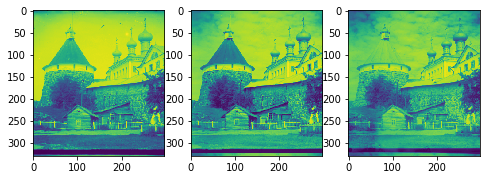

In [81]:
# size of half the side of the square in which we will chose the corner to try superpositions, in pixels.

size = 20

# careful !! size = 5 => 3 mins, size = 10 => 15 mins

# function finding the best superposition, taking two pictures and a size, and returning the corner.
def find_best_supp(im_a, im_b, size):
    best_score = 10000000000000000000000
    best_corner = (0,0)
    for i in range(size, -size, -1):
        for j in range(size, -size, -1):
            im_a_t, im_b_t = reshape(im_a, im_b, (i, j))
            # print(str((i,j)))
            current_score = evaluate_superposition(im_a_t, im_b_t)
            if current_score < best_score:
                # print("previous best value was " + str(current_score) + " for corner " + str(best_corner))
                best_score = current_score
                best_corner = (i, j)
                # print("new best value is " + str(current_score) + " for corner " + str(best_corner))
    return(best_corner)

# function taking the three pictures, the size, and returning the 3 pictures reshaped and ready to compile.
def reshape_images(im_a, im_b, im_c, size):
    corner_a_b = find_best_supp( im_a, im_b, size)
    corner_a_c = find_best_supp( im_a, im_c, size)
    
    im_a, im_b = reshape(im_a, im_b, corner_a_b)
    im_a, im_c = reshape(im_a, im_c, corner_a_c)

    return(im_a, im_b, im_c)

# let's make some tests again.

im_red_t, im_green_t, im_blue_t = reshape_images(im_red, im_green, im_blue, size)

rows = 1
columns = 3
fig = plt.figure(figsize = (8,8))
fig.add_subplot(rows, columns, 1)
plt.imshow(im_red_t)
fig.add_subplot(rows, columns, 2)
plt.imshow(im_green_t)
fig.add_subplot(rows, columns, 3)
plt.imshow(im_blue_t)

plt.show()

(330, 298)
(330, 298)
(330, 298)


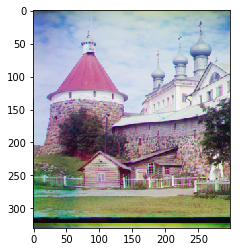

In [82]:
print(im_red_t.shape)
print(im_green_t.shape)
print(im_blue_t.shape)

im_colour = cv2.merge((im_blue_t,im_green_t,im_red_t))

# im_colour = [[[im_blue_t[i][j], im_green_t[i][j], im_red_t[i][j]] for j in range(im_red_t.shape[1])] 
#              for i in range(im_red_t.shape[0])]

im_colour = numpy.asarray(im_colour)
# im_colour = numpy.flip(im_colour, 1)
# im_colour = numpy.flip(im_colour, 0)

plt.imshow(im_colour)
plt.show()


# two problem : wrong dimensions for one of the arrays, problem when 3 images are compiled into one coloured image